In [ ]:
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')
zipped_path = '/content/drive/MyDrive/data.zip'
spy_data = '/content/TradesSPY.zip'

In [ ]:
from zipfile import ZipFile
  
file_name = spy_data
  
with ZipFile(file_name, 'r') as zip:
    zip.printdir()
  
    print('Extracting all the files now...')
    zip.extractall()
    print('Done!')

In [ ]:
import glob
import os


unzip_data = '/content/TradesSPY'

all_files = os.listdir(unzip_data)    
csv_files = list(filter(lambda f: f.endswith('.csv'), all_files))

df_append = pd.DataFrame()
#append all files together
for file in csv_files:
    df_temp = pd.read_csv(unzip_data+'/'+file)
    df_append = df_append.append(df_temp, ignore_index=True)
df_append

In [ ]:
mean_price = df_append['PRICE'].mean()
std_price = df_append['PRICE'].std()
df_append['PRICE'] = df_append['PRICE'].apply(lambda x: (x - mean_price)/std_price)
df_append = df_append.drop('MESSAGE_ID', axis=1)
df_append = df_append.drop('MESSAGE_TYPE', axis=1)
df_append = df_append.drop('SYMBOL', axis=1)
df_append = df_append.drop('SIZE', axis=1)
df_append = df_append.drop('TRADE_ID', axis=1)
df_append = df_append.drop('TRADE_FLAGS', axis=1)
df_append


In [ ]:
import datetime
import zipfile

def str_to_datetime(s):
  split = s.split('-')
  year, month, day = int(split[0]), int(split[1]), int(split[2])
  return datetime.datetime(year=year, month=month, day=day)

datetime_object = str_to_datetime('1986-03-19')
datetime_object

datetime.datetime(1986, 3, 19, 0, 0)

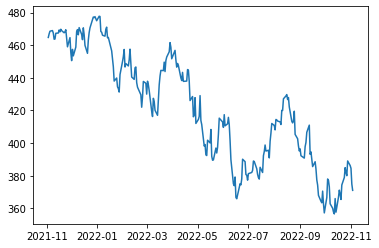

In [ ]:
import matplotlib.pyplot as plt

plt.plot(df.index, df['Close'])

In [ ]:
import numpy as np

def df_to_windowed_df(dataframe, first_date_str, last_date_str, n=3):
  first_date = str_to_datetime(first_date_str)
  last_date  = str_to_datetime(last_date_str)

  target_date = first_date
  
  dates = []
  X, Y = [], []

  last_time = False
  while True:
    df_subset = dataframe.loc[:target_date].tail(n+1)
    
    if len(df_subset) != n+1:
      print(f'Error: Window of size {n} is too large for date {target_date}')
      return

    values = df_subset['Close'].to_numpy()
    x, y = values[:-1], values[-1]

    dates.append(target_date)
    X.append(x)
    Y.append(y)

    next_week = dataframe.loc[target_date:target_date+datetime.timedelta(days=7)]
    next_datetime_str = str(next_week.head(2).tail(1).index.values[0])
    next_date_str = next_datetime_str.split('T')[0]
    year_month_day = next_date_str.split('-')
    year, month, day = year_month_day
    next_date = datetime.datetime(day=int(day), month=int(month), year=int(year))
    
    if last_time:
      break
    
    target_date = next_date

    if target_date == last_date:
      last_time = True
    
  ret_df = pd.DataFrame({})
  ret_df['Target Date'] = dates
  
  X = np.array(X)
  for i in range(0, n):
    X[:, i]
    ret_df[f'Target-{n-i}'] = X[:, i]
  
  ret_df['Target'] = Y

  return ret_df

# Start day second time around: '2021-03-25'
windowed_df = df_to_windowed_df(df, 
                                '2021-11-9', 
                                '2022-11-03', 
                                n=3)
windowed_df

Target Date    Target-3    Target-2    Target-1      Target
0    2021-11-09  466.910004  468.529999  468.929993  467.380005
1    2021-11-10  468.529999  468.929993  467.380005  463.619995
2    2021-11-11  468.929993  467.380005  463.619995  463.769989
3    2021-11-12  467.380005  463.619995  463.769989  467.269989
4    2021-11-15  463.619995  463.769989  467.269989  467.429993
..          ...         ...         ...         ...         ...
244  2022-10-28  384.920013  382.019989  379.980011  389.019989
245  2022-10-31  382.019989  379.980011  389.019989  386.209991
246  2022-11-01  379.980011  389.019989  386.209991  384.519989
247  2022-11-02  389.019989  386.209991  384.519989  374.869995
248  2022-11-03  386.209991  384.519989  374.869995  371.010010

[249 rows x 5 columns]

In [ ]:
def windowed_df_to_date_X_y(windowed_dataframe):
  df_as_np = windowed_dataframe.to_numpy()

  dates = df_as_np[:, 0]

  middle_matrix = df_as_np[:, 1:-1]
  X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1))

  Y = df_as_np[:, -1]

  return dates, X.astype(np.float32), Y.astype(np.float32)

dates, X, y = windowed_df_to_date_X_y(windowed_df)

dates.shape, X.shape, y.shape

((249,), (249, 3, 1), (249,))

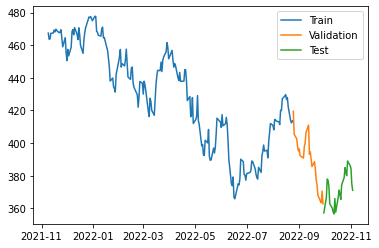

In [ ]:
q_80 = int(len(dates) * .8)
q_90 = int(len(dates) * .9)

dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]

dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]
dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:]

plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)

plt.legend(['Train', 'Validation', 'Test'])

In [ ]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df_append, test_size=0.2)
print(train.shape)
print(test.shape)


In [ ]:
import numpy as np

X_train = []
Y_train = []
prediction_buf = 20
data_array = df_append['PRICE'].tolist()

for x in range(prediction_buf,len(data_array)):
  X_train.append(data_array[x-prediction_buf:x])
  Y_train.append(data_array[x])
X_train = np.array(X_train)
Y_train = np.array(Y_train)
X_train = np.reshape(X_train,(X_train.shape[0],X_train.shape[1],1))
print(X_train.shape)
print(Y_train.shape)


(3959014, 20, 1)
(3959014,)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
import time

model = Sequential([layers.Input((X_train.shape[1], 1)),
                    layers.LSTM(128),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

model.compile(loss='mse', 
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])
start = time.time()
model.fit(X_train, Y_train, epochs=1, batch_size = 32)
stop = time.time()
print(start,stop)

123720/123720 [==============================] - 2743s 22ms/step - loss: 3.0824e-04 - mean_absolute_error: 0.0026
1671746741.7745526 1671749525.589066


10.792895317077637
7/7 [==============================] - 0s 4ms/step


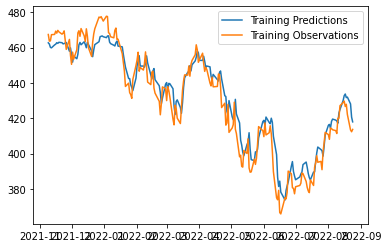

In [ ]:
print(stop-start)
train_predictions = model.predict(X_train).flatten()

plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.legend(['Training Predictions', 'Training Observations'])

1/1 [==============================] - 0s 17ms/step


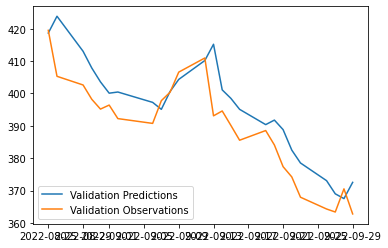

In [ ]:
val_predictions = model.predict(X_val).flatten()

plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.legend(['Validation Predictions', 'Validation Observations'])

1/1 [==============================] - 0s 17ms/step


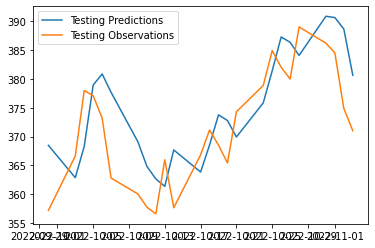

In [ ]:
test_predictions = model.predict(X_test).flatten()

plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Testing Predictions', 'Testing Observations'])

In [ ]:
[test_loss,test_acc] = model.evaluate(X_test,y_test)
print('test accuracy: ',test_acc,'%')
print('test loss: ',test_loss)

1/1 [==============================] - 0s 24ms/step - loss: 55.3329 - mean_absolute_error: 6.6370
test accuracy:  6.636986255645752 %
test loss:  55.3328742980957


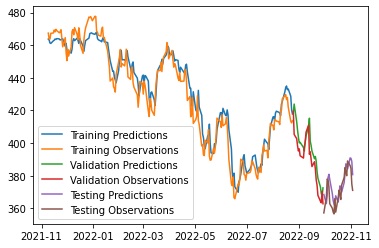

In [ ]:
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Training Predictions', 
            'Training Observations',
            'Validation Predictions', 
            'Validation Observations',
            'Testing Predictions', 
            'Testing Observations'])

In [ ]:
from copy import deepcopy

recursive_predictions = []
recursive_dates = np.concatenate([dates_val, dates_test])

for target_date in recursive_dates:
  last_window = deepcopy(X_train[-1])
  next_prediction = model.predict(np.array([last_window])).flatten()
  recursive_predictions.append(next_prediction)
  last_window[-1] = next_prediction

1/1 [==============================] - 0s 15ms/step


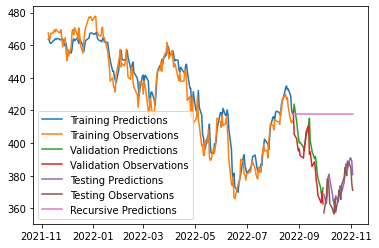

In [ ]:
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.plot(recursive_dates, recursive_predictions)
plt.legend(['Training Predictions', 
            'Training Observations',
            'Validation Predictions', 
            'Validation Observations',
            'Testing Predictions', 
            'Testing Observations',
            'Recursive Predictions'])